## Importing Dependencies

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
import time
from PIL import Image
from sklearn.metrics import r2_score, mean_squared_error
from tqdm.notebook import tqdm

## Directories to access training data

In [2]:
images_directory = '/content/drive/MyDrive/Emmen_28_images/images'
excel_file_directory = '/content/drive/MyDrive/Emmen_28.xlsx'

## speedData class to create datasets

In [3]:
class speedData(Dataset):
    def __init__(self, excel_file_directory, images_directory, transform = None):
        self.excel_file_directory = excel_file_directory
        self.images_directory = images_directory
        self.transform = transform
        
        # Load excel file into dataframe
        self.df = pd.read_excel(excel_file_directory)
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):          
        # Image and label selection from dataframe
        image_df, label = self.df.iloc[index]['cameraRight'], self.df.iloc[index]['canSpeed']
        
        # Image file path
        imgage_dir = self.images_directory + str(image_df[-13:])

        # Opening image 
        image = Image.open(imgage_dir)

        # Apply transforms if applicable
        if self.transform:
            image = self.transform(image)
            label = torch.tensor(label)
            label = label.view(1,)
        return image, label

## Transforms for datasets

In [4]:
data_transforms = transforms.Compose([transforms.Resize(256), 
                                      transforms.ToTensor(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

## Instantiate a dataset with transforms

In [5]:
data = speedData(excel_file_directory, images_directory, data_transforms)

In [6]:
# Viewing sample data from dataset
data[0]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

## Split dataset into training and validation subsets

In [7]:
# Length of traning subset
train_size = int(0.8 * len(data))

# Length of validation subset
validation_size = len(data) - train_size

# Split data in the ratio 8:2 for training and validation
train_data, validation_data = random_split(data, [train_size, validation_size], torch.Generator().manual_seed(42))

In [8]:
# View sample from training set
train_data[0]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [9]:
# Length of training set
len(train_data)

2397

In [10]:
# View sample from validation set
validation_data[0]

(tensor([[[ 0.9474,  0.9303,  0.9303,  ..., -2.1179, -2.1179, -2.1179],
          [ 0.9988,  0.9988,  0.9817,  ...,  0.0227,  0.0056,  0.0056],
          [ 0.9817,  1.0159,  0.9988,  ...,  0.0227,  0.0056,  0.0056],
          ...,
          [ 0.6221,  0.6221,  0.6392,  ...,  0.0741,  0.0569,  0.0569],
          [ 0.6221,  0.6221,  0.6563,  ...,  0.0569,  0.0569,  0.0569],
          [-2.1179, -2.1179, -2.1179,  ...,  0.0398,  0.0569,  0.0569]],
 
         [[ 0.9755,  0.9580,  0.9580,  ..., -2.0357, -2.0357, -2.0357],
          [ 1.0280,  1.0280,  1.0105,  ...,  0.8354,  0.8179,  0.8179],
          [ 1.0105,  1.0280,  1.0105,  ...,  0.8354,  0.8179,  0.8179],
          ...,
          [ 0.5903,  0.5903,  0.6078,  ...,  0.1176,  0.1001,  0.1001],
          [ 0.5903,  0.5903,  0.6254,  ...,  0.1001,  0.1001,  0.1001],
          [-2.0357, -2.0357, -2.0357,  ...,  0.0826,  0.1001,  0.1001]],
 
         [[ 0.9145,  0.8971,  0.8971,  ..., -1.8044, -1.8044, -1.8044],
          [ 0.9668,  0.9668,

In [11]:
# Length of validation set
len(validation_data)

600

## Loading Training and Validation data into batch sizes of 128

In [12]:
train_img_dataloader = DataLoader(train_data, batch_size=128, 
                                  shuffle=True)
validation_img_dataloader = DataLoader(validation_data, batch_size=128)

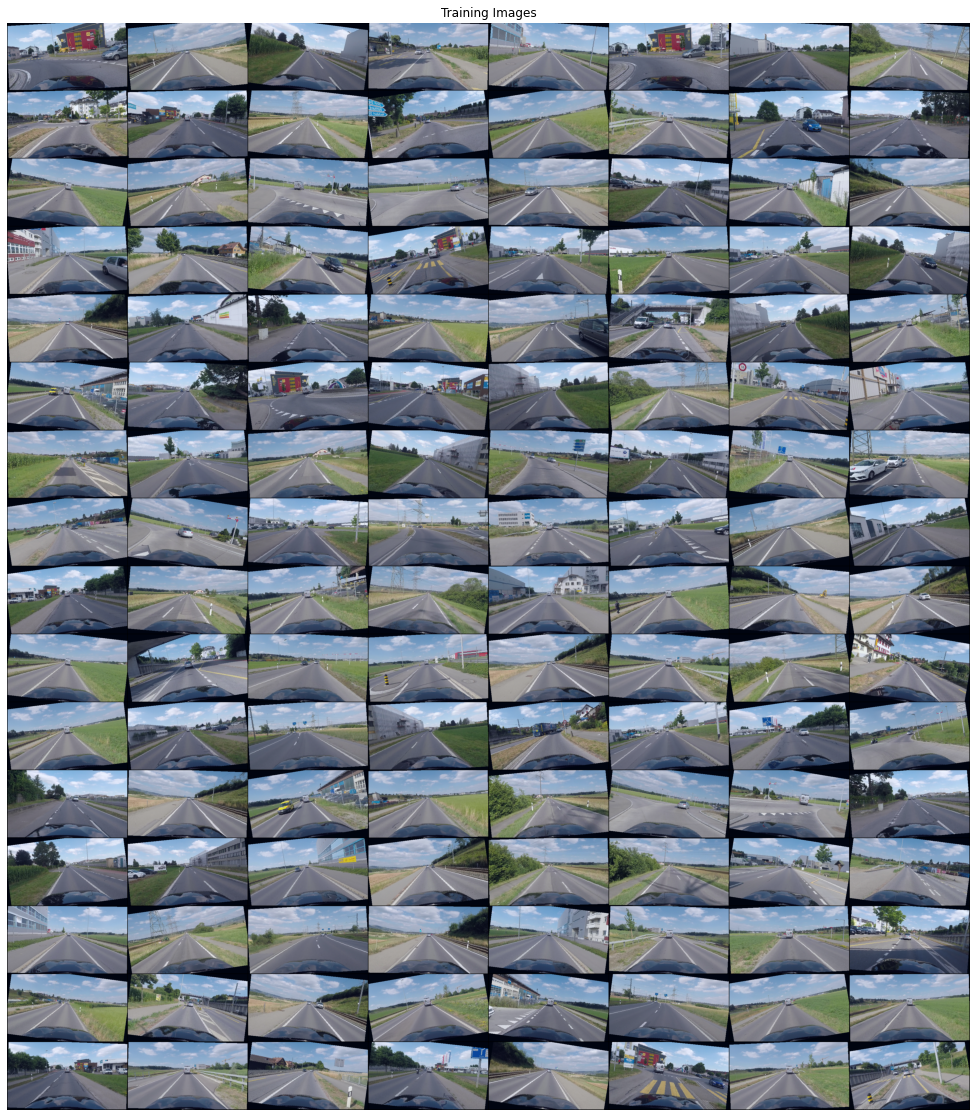

In [13]:
# Viewing a batch of training data
train_batch = next(iter(train_img_dataloader))
plt.figure(figsize=(20,20))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(train_batch[0], padding=2, normalize=True).cpu(),(1,2,0)))

## Building Model

In [15]:
class NeuralNet(nn.Module):
  def __init__(self):
    super(NeuralNet, self).__init__()

    # Using pretrained ResNet34 model 
    self.model = models.resnet34(pretrained=True)

    # Getting all but last layer of of model
    self.all_features = nn.Sequential(*list(self.model.children())[:-1])

    # Setting up an intermediate layer between ResNet34 layers and customized output layer
    self.intermediate = nn.Sequential(nn.Linear(self.model.fc.in_features, 128), nn.ReLU())

    # Output layer
    self.speed_out = nn.Sequential(nn.Linear(128, 64), nn.ReLU(),
                                  nn.Linear(64, 32), nn.ReLU(),
                                  nn.Linear(32, 1))
  
  def forward(self, x):

      y = self.all_features(x)
      y = y.view(y.size(0), -1)
      y = self.intermediate(y)
      y = self.speed_out(y)
      return y

In [16]:
# Instantiate a model object
model34 = NeuralNet()

In [17]:
# Freeze model parameters
# for parameter in model34.parameters():
#   parameter.required_grad = False

In [18]:
# Loss function
loss_function = nn.MSELoss()

# Optimizer to optimize model parameters
optimizer = torch.optim.Adam(model34.parameters(), lr=0.001)

# Scheduler to step learning rate by a factor of 0.1 every 5 epochs
step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Number of epochs
num_epochs = 20

## Setting up GPU if available

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model34 = model34.to(device)

## Training and Validation Step

In [20]:
def train_validate_model(model, criterion, optimizer, scheduler, num_epochs):
    
    # Copy model parameters
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # Start time to track training
    start_time = time.time()
    
    # Metrcis to track entire training and validation loss and score
    best_r2 = 0.0
    loss_min = np.inf
    
    training_loss = []
    validation_loss = []
    training_score = []
    validation_score = []

    for epoch in range(num_epochs):
        
        # Set model to training mode
        model.train()

        # Training loss and score per epoch
        train_loss = 0.0
        r2_train = 0

        for inputs, labels in tqdm(train_img_dataloader):
            
            # Send inputs and labels to GPU is available 
            inputs = inputs.to(device)    
            labels = labels.to(device)

            # Set up backward propagation
            with torch.set_grad_enabled(True):

                # Reset model parameters
                optimizer.zero_grad()
                
                # Forward pass and loss calculation
                outputs = model(inputs)
                loss = criterion(outputs.float(), labels.float())

                # Send model output and labels to cpu to calculate r2 score
                outputs = outputs.to('cpu')
                labels = labels.to('cpu')
                r2 = r2_score(outputs.detach().numpy(), labels.detach().numpy())
                
                # Backward pass and optimze model parameters
                loss.backward()
                optimizer.step()
                
                # Update training loss and score per epoch
                train_loss += loss.item()
                r2_train += r2

        # Update learning rate with scheduler
        scheduler.step()

        # Compute training loss and score per epoch
        epoch_train_loss = train_loss / len(train_img_dataloader)
        training_loss.append(epoch_train_loss)
        r_squared_train = r2_train / len(train_img_dataloader)
        training_score.append(r_squared_train)
        print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Train R Squared: {r_squared_train:.4f}')
        
        
        # Set model to evaluation mode
        model.eval()

        # Validation loss and score per epoch
        test_loss = 0.0
        r2_validation = 0

        for inputs, labels in validation_img_dataloader:

            # Send inputs and labels to GPU is available 
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Making sure backward propagation is disabled in order not to compute gradients
            with torch.no_grad():

                # Forward pass and loss calculation
                outputs = model(inputs)
                loss = criterion(outputs.float(), labels.float())

                # Send model output and labels to cpu to calculate r2 score
                outputs = outputs.to('cpu')
                labels = labels.to('cpu')
                r2 = r2_score(outputs.detach().numpy(), labels.detach().numpy())

                # Update validation loss and score per epoch
                test_loss += loss.item()
                r2_validation += r2

        # Compute validation loss and score per epoch
        epoch_test_loss = test_loss / len(validation_img_dataloader)
        validation_loss.append(epoch_test_loss)
        r_squared_test = r2_validation / len(validation_img_dataloader)
        validation_score.append(r_squared_test)
        print(f'Epoch {epoch+1}, Validation Loss: {epoch_test_loss:.4f}, Validation R Squared: {r_squared_test:.4f}')

        # Setting up requirements to copy best model parameters
        if epoch_test_loss < loss_min and best_r2 < r_squared_test:
                loss_min = epoch_test_loss
                best_r2 = r_squared_test
                best_model_wts = copy.deepcopy(model.state_dict())

    # Checking duration of entire training step
    time_elapsed = time.time() - start_time
    print(f'Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s and best R2 recorded is {best_r2:.4f}')
    model.load_state_dict(best_model_wts)

    return model, training_loss, validation_loss, training_score, validation_score

In [21]:
model34, training_loss, validation_loss, training_score, validation_score = train_validate_model(model34, loss_function, optimizer, step_lr_scheduler, num_epochs)

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 1, Train Loss: 129.3569, Train R Squared: -97337.4768
Epoch 1, Validation Loss: 86.2172, Validation R Squared: -6.7449


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 2, Train Loss: 5.7964, Train R Squared: 0.6382
Epoch 2, Validation Loss: 27.0179, Validation R Squared: -0.0818


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.9012, Train R Squared: 0.9469
Epoch 3, Validation Loss: 5.0972, Validation R Squared: 0.7576


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.8431, Train R Squared: 0.9497
Epoch 4, Validation Loss: 0.6425, Validation R Squared: 0.9485


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.5283, Train R Squared: 0.9699
Epoch 5, Validation Loss: 0.5226, Validation R Squared: 0.9563


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 6, Train Loss: 0.3951, Train R Squared: 0.9757
Epoch 6, Validation Loss: 0.2759, Validation R Squared: 0.9832


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 7, Train Loss: 0.3496, Train R Squared: 0.9799
Epoch 7, Validation Loss: 0.1607, Validation R Squared: 0.9895


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 8, Train Loss: 0.3123, Train R Squared: 0.9822
Epoch 8, Validation Loss: 0.1684, Validation R Squared: 0.9887


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 9, Train Loss: 0.2670, Train R Squared: 0.9847
Epoch 9, Validation Loss: 0.1552, Validation R Squared: 0.9899


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 10, Train Loss: 0.2948, Train R Squared: 0.9828
Epoch 10, Validation Loss: 0.1306, Validation R Squared: 0.9914


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 11, Train Loss: 0.2914, Train R Squared: 0.9836
Epoch 11, Validation Loss: 0.1264, Validation R Squared: 0.9918


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 12, Train Loss: 0.2731, Train R Squared: 0.9848
Epoch 12, Validation Loss: 0.1314, Validation R Squared: 0.9916


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 13, Train Loss: 0.1926, Train R Squared: 0.9892
Epoch 13, Validation Loss: 0.1309, Validation R Squared: 0.9915


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 14, Train Loss: 0.2420, Train R Squared: 0.9862
Epoch 14, Validation Loss: 0.1213, Validation R Squared: 0.9922


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 15, Train Loss: 0.2584, Train R Squared: 0.9854
Epoch 15, Validation Loss: 0.1238, Validation R Squared: 0.9922


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 16, Train Loss: 0.2688, Train R Squared: 0.9850
Epoch 16, Validation Loss: 0.1432, Validation R Squared: 0.9907


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 17, Train Loss: 0.2362, Train R Squared: 0.9867
Epoch 17, Validation Loss: 0.1310, Validation R Squared: 0.9916


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 18, Train Loss: 0.2191, Train R Squared: 0.9880
Epoch 18, Validation Loss: 0.1340, Validation R Squared: 0.9913


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 19, Train Loss: 0.2608, Train R Squared: 0.9853
Epoch 19, Validation Loss: 0.1250, Validation R Squared: 0.9920


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 20, Train Loss: 0.1908, Train R Squared: 0.9893
Epoch 20, Validation Loss: 0.1368, Validation R Squared: 0.9912
Training completed in 49m 43s and best R2 recorded is 0.9922


## Visualize training and validation metrics

Text(0, 0.5, 'Score')

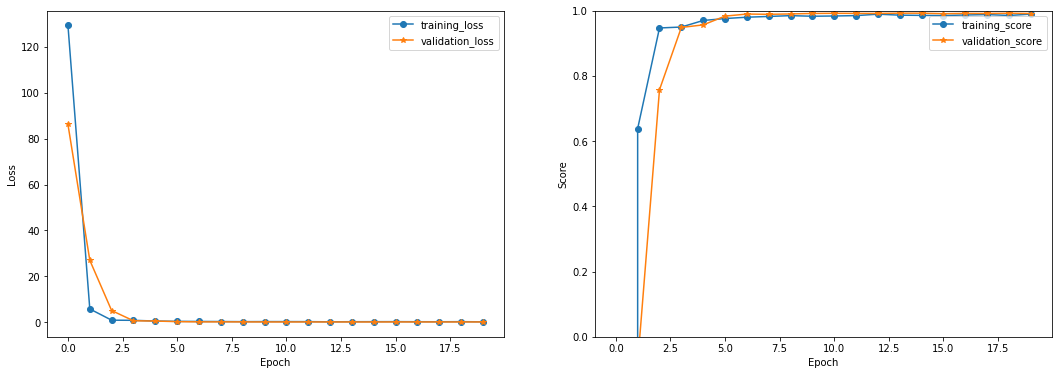

In [22]:
plt.figure(figsize = (18, 6))
plt.subplot(1, 2, 1)
plt.plot(list(range(num_epochs)), training_loss, marker = 'o')
plt.plot(list(range(num_epochs)), validation_loss, marker = '*')
plt.legend(['training_loss', 'validation_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(list(range(num_epochs)), training_score, marker = 'o')
plt.plot(list(range(num_epochs)), validation_score, marker = '*')
plt.ylim([0,1])
plt.legend(['training_score', 'validation_score'])
plt.xlabel('Epoch')
plt.ylabel('Score')

## Testing the Model

In [23]:
# test images directory
test_images_directory = '/content/drive/MyDrive/Emmen_28_images/images'

In [24]:
test_file_directory = '/content/drive/MyDrive/Emmen_27.xlsx'

In [25]:
# Loading test images and labels
test_data = speedData(test_file_directory, test_images_directory, transforms.ToTensor())

In [26]:
# Viewing sample test data
test_data[0]

(tensor([[[0.3882, 0.3490, 0.3529,  ..., 0.9686, 0.9686, 0.9686],
          [0.3922, 0.3529, 0.3529,  ..., 0.9647, 0.9647, 0.9647],
          [0.3961, 0.3529, 0.3490,  ..., 0.9647, 0.9647, 0.9647],
          ...,
          [0.3686, 0.3647, 0.3647,  ..., 0.5020, 0.5020, 0.5020],
          [0.3686, 0.3647, 0.3608,  ..., 0.5020, 0.5020, 0.5020],
          [0.3686, 0.3647, 0.3608,  ..., 0.5020, 0.5020, 0.5020]],
 
         [[0.4627, 0.4235, 0.4275,  ..., 0.9608, 0.9608, 0.9608],
          [0.4667, 0.4275, 0.4275,  ..., 0.9569, 0.9569, 0.9569],
          [0.4706, 0.4275, 0.4235,  ..., 0.9569, 0.9569, 0.9569],
          ...,
          [0.3569, 0.3529, 0.3529,  ..., 0.4706, 0.4706, 0.4706],
          [0.3569, 0.3529, 0.3490,  ..., 0.4706, 0.4706, 0.4706],
          [0.3569, 0.3529, 0.3490,  ..., 0.4706, 0.4706, 0.4706]],
 
         [[0.5216, 0.4824, 0.4863,  ..., 0.9804, 0.9804, 0.9804],
          [0.5255, 0.4863, 0.4863,  ..., 0.9765, 0.9765, 0.9765],
          [0.5294, 0.4863, 0.4824,  ...,

In [27]:
# Function to load model and predictions
def predict_single_input(image, model, label):
  plt.imshow(np.transpose(vutils.make_grid(image, padding=2, normalize=True).cpu(),(1,2,0)))
  plt.axis('off')
  image = image.unsqueeze(0).to(device)
  speed_predict = model(image)
  speed_predict = speed_predict.to('cpu').detach().numpy()
  print(f'Predicted Speed: {speed_predict.item()}, Actual Speed: {label.item()}')
  print(f'Loss: {mean_squared_error([speed_predict.item()], [label.item()])}')
  return speed_predict.item(), label.item()

Predicted Speed: 18.329132080078125, Actual Speed: 14.473478
Loss: 14.866068385223091


(18.329132080078125, 14.473478)

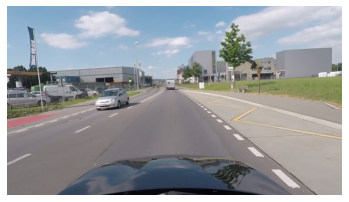

In [36]:
predict_single_input(test_data[775][0], model34, test_data[775][1])

Predicted Speed: 18.7030029296875, Actual Speed: 11.104139
Loss: 57.74273302190576


(18.7030029296875, 11.104139)

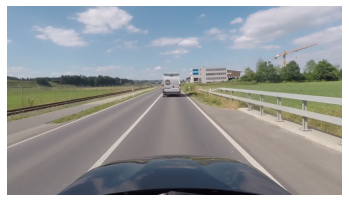

In [37]:
predict_single_input(test_data[1168][0], model34, test_data[1168][1])

Predicted Speed: 18.23863410949707, Actual Speed: 8.803087
Loss: 89.02954925553853


(18.23863410949707, 8.803087)

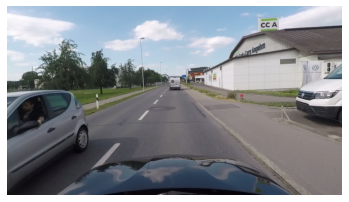

In [30]:
predict_single_input(test_data[10][0], model34, test_data[10][1])

Predicted Speed: 18.58909797668457, Actual Speed: 12.34691
Loss: 38.964910736265416


(18.58909797668457, 12.34691)

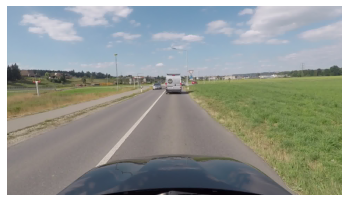

In [38]:
predict_single_input(test_data[1532][0], model34, test_data[1532][1])

Predicted Speed: 19.481258392333984, Actual Speed: 13.757102
Loss: 32.76596640389802


(19.481258392333984, 13.757102)

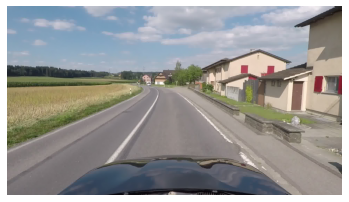

In [39]:
predict_single_input(test_data[2953][0], model34, test_data[2953][1])